<a href="https://colab.research.google.com/github/rohandawar/ProcessMining/blob/main/ProcessMining_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I am trying to learn processing mining through ** Health Care** industry example

In [25]:
! pip install pm4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
# Import Libs 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ipython
from IPython.display import display, Markdown

# Pm4py
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

# Process mining
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery

# Viz

from pm4py.visualization.petri_net import visualizer as pn_visualizer


In [27]:
# Function Defination
def printmd(string):
  display(Markdown(string))

In [28]:
#https://gitlab.com/healthcare2/process-mining-tutorial
#https://medium.com/@c3_62722/process-mining-with-python-tutorial-a-healthcare-application-part-2-4cf57053421f

In [29]:
data_path = 'https://gitlab.com/healthcare2/process-mining-tutorial/-/raw/master/ArtificialPatientTreatment.csv'
events = pd.read_csv(data_path)
events.head()

,patient,action,org:resource,DateTime
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11
1,patient 0,Blood test,Lab,2017-01-02 12:47:33
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09


In [30]:
# renaming the columns to have a better shape
events.columns = ['patient', 'action', 'resources', 'datetime']

# Change the event to date time 
events['datetime'] = pd.to_datetime(events['datetime'])
events.head()

,patient,action,resources,datetime
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11
1,patient 0,Blood test,Lab,2017-01-02 12:47:33
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09


In [31]:
# Get the case start time
case_start_ends = events.pivot_table(index='patient', aggfunc={'datetime':['min', 'max']})
case_start_ends = case_start_ends.reset_index()
case_start_ends.columns = ['patient', 'caseend', 'casestart']
case_start_ends.head()



,patient,caseend,casestart
0,patient 0,2017-01-09 08:29:28,2017-01-02 11:40:11
1,patient 1,2017-01-06 16:49:21,2017-01-02 12:50:35
2,patient 10,2017-01-30 11:19:19,2017-01-17 14:13:17
3,patient 11,2017-02-02 10:13:13,2017-01-19 13:35:20
4,patient 12,2017-01-27 11:18:57,2017-01-20 11:43:38


In [32]:
# Merging the 2 dataframes to have the case start time & end time for every patient
events = events.merge(case_start_ends, on='patient')
events['relativetime'] = events['datetime'] - events['casestart']
events['action'] = events['action'].apply(lambda x : x.strip())
events.head()

,patient,action,resources,datetime,caseend,casestart,relativetime
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58


In [33]:
delimiter = '___'

makeEventString = lambda x: delimiter.join(x)
makeEventString.__name__ = 'makeEventString'

numEvents = lambda x: len(x)
numEvents.__name__ = 'numEvents'


caselogs = events.pivot_table(index='patient', aggfunc={'action': [makeEventString, numEvents]})
caselogs = caselogs.reset_index()
caselogs.columns = ['patient', 'action_sequence', 'numactions']

events = pd.merge(events, caselogs, on='patient')
events['caselength'] = events['caseend'] - events['casestart']

events.head()

,patient,action,resources,datetime,caseend,casestart,relativetime,action_sequence,numactions,caselength
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,First consult___Blood test___Physical test___S...,6,6 days 20:49:17
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,First consult___Blood test___Physical test___S...,6,6 days 20:49:17
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,First consult___Blood test___Physical test___S...,6,6 days 20:49:17
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,First consult___Blood test___Physical test___S...,6,6 days 20:49:17
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,First consult___Blood test___Physical test___S...,6,6 days 20:49:17


In [34]:
 ## Get day of week
events['weekday'] = events['datetime'].apply(lambda x: x.weekday())
events['date'] = events['datetime'].apply(lambda x: x.date())
events['startdate'] = events['casestart'].apply(lambda x: x.date())
events['hour'] = events['datetime'].apply(lambda x: x.time().hour)
## Get relative times in more friendly terms
events['relativetime_s'] = events['relativetime'].dt.seconds + 86400*events['relativetime'].dt.days
events['relativedays'] = events['relativetime'].dt.days

In [35]:
events.head()

,patient,action,resources,datetime,caseend,casestart,relativetime,action_sequence,numactions,caselength,weekday,date,startdate,hour,relativetime_s,relativedays
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,0,2017-01-02,2017-01-02,11,0,0
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,0,2017-01-02,2017-01-02,12,4042,0
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,0,2017-01-02,2017-01-02,12,4419,0
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,0,2017-01-02,2017-01-02,16,16855,0
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,3,2017-01-05,2017-01-02,13,265378,3


In [38]:
events.head()

,patient,action,resources,datetime,caseend,casestart,relativetime,action_sequence,numactions,caselength,weekday,date,startdate,hour,relativetime_s,relativedays
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,0,2017-01-02,2017-01-02,11,0,0
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,0,2017-01-02,2017-01-02,12,4042,0
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,0,2017-01-02,2017-01-02,12,4419,0
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,0,2017-01-02,2017-01-02,16,16855,0
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,3,2017-01-05,2017-01-02,13,265378,3


In [36]:
eventlog = events.copy()
### Specify which columns correspond to case (case:concept:name), 
###event (concept:name) and timestamp (time:timestamp) - rename columns in accordance
###with pm4py

eventlog.rename(columns={'datetime': 'time:timestamp', 'patient': 'case:concept:name', 'action': 'concept:name', 'resource': 'org:resource'}, inplace=True)

## Convert to log format
log = log_converter.apply(eventlog)

In [39]:
eventlog.head()

,case:concept:name,concept:name,resources,time:timestamp,caseend,casestart,relativetime,action_sequence,numactions,caselength,weekday,date,startdate,hour,relativetime_s,relativedays
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,0,2017-01-02,2017-01-02,11,0,0
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,0,2017-01-02,2017-01-02,12,4042,0
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,0,2017-01-02,2017-01-02,12,4419,0
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,0,2017-01-02,2017-01-02,16,16855,0
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,3,2017-01-05,2017-01-02,13,265378,3


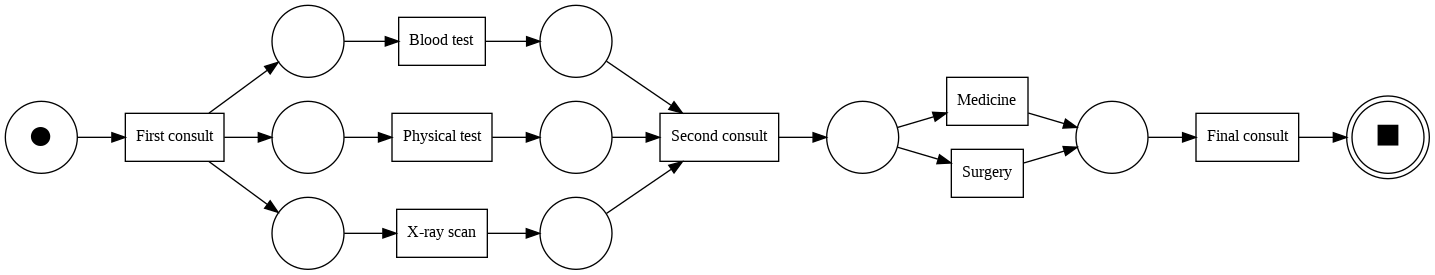

In [37]:
# alpha miner
net, initial_marking, final_marking = alpha_miner.apply(log)

# Visualise
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)